# IDS Bayesian Interferometry

In [1]:
from pymc3 import *
import numpy as np

In [44]:
def show_fft_image(img_fft, shift = True):
    
    img_fftabs = img_fft
    if type(img_fft[0,0]) == np.complex128:
        img_fftabs = np.abs(img_fft)
    
    if shift:
        img_fftabs = np.fft.fftshift(img_fftabs)
    plt.imshow(img_fftabs)
    plt.show()

## Creating artificial data

In [3]:
size = 1
MAX_VALUE = 255
MIN_VALUE = 0
IMAGE_SIZE_X = 50
IMAGE_SIZE_Y = 50
SIGMA = 20

I = np.ceil((MAX_VALUE - MIN_VALUE) * np.random.rand(size) + MIN_VALUE)
Cx = np.ceil((IMAGE_SIZE_X)/2 + SIGMA*np.random.randn(size)).astype('int')
Cx = np.clip(Cx,0,255)
Cy = np.ceil((IMAGE_SIZE_Y)/2 +  SIGMA*np.random.randn(size)).astype('int')
Cy = np.clip(Cy,0,255)

minI = np.min(I)
argminI = np.argmin(I)
maxI = np.max(I)
argmaxI = np.argmax(I)

print 'min I: %s at (%s,%s)\n' \
      'max I: %s at (%s,%s)\n' % (minI, Cx[argminI], Cy[argminI],
                                  maxI, Cx[argmaxI], Cy[argmaxI])

min I: 179.0 at (38,44)
max I: 179.0 at (38,44)



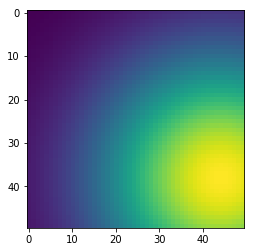

In [4]:
import matplotlib.pyplot as plt
from modelfunctions import *

Im_sinthc = sintheticImage(I,Cx,Cy, l=SIGMA, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_Y)
plt.imshow(Im_sinthc)
plt.show()

img = Im_sinthc #rename variable

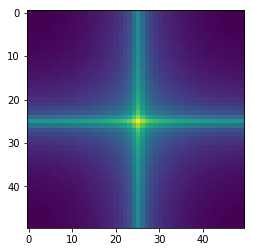

In [5]:
# Calculate the spectrum
img_fft, img_fftabs = spectrum(img)

show_fft_image(np.log(img_fftabs+1e-12))

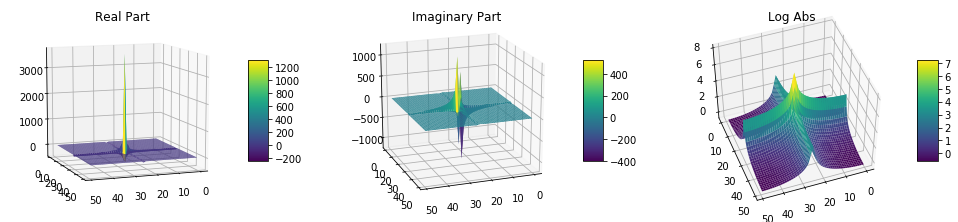

In [35]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# 3D plotting
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 3, 1, projection='3d')


UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = np.fft.fftshift(img_fft.real)


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Real Part")

ax.view_init(elev=10., azim = 70)

# 3D plotting
ax = fig.add_subplot(1, 3, 2, projection='3d')


UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = np.fft.fftshift(img_fft.imag)


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Imaginary Part")

ax.view_init(elev=20., azim = 70)

# 3D plotting
ax = fig.add_subplot(1, 3, 3, projection='3d')

UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = np.fft.fftshift(np.log(img_fftabs+0.001))


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Log Abs")

ax.view_init(elev=50., azim = 70)

fig.set_figheight(3.7)
fig.set_figwidth(17)

plt.show(fig)

## Creating sampling mask


For creating the sampling mask, we have made a u,v representations based on the antennas disposition. This is because, if the antennas disposition is random, the measures are not completely random. The Measurements positions are defined by the interferometry physics.

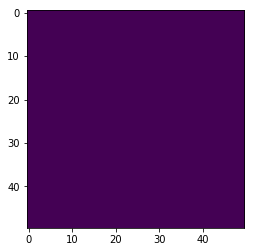

In [7]:
from masking import *

## Parameters
B_max = 1
antennas = 24
typeArray = 'ALL'
sigma = B_max/6

lambda_phy=3*10**(-6); #(km)
H0=10; #(deg)
delta0=-30; #(deg)
Lat=34.05;  #(deg) Lat VLA

## Masking function returns the mask
mask = createSpectrumMasking(B_max,antennas,typeArray,sigma, lambda_phy, H0, delta0, Lat, N1 = IMAGE_SIZE_X, N2 = IMAGE_SIZE_Y)
show_fft_image(mask)

## Sampling

Variable `measurements` are the 2D representation for the measurements. `U` are the positions in the `u,v` spaces, i.e., `U[0] = u`, `U[1] = v`. Finally, `V` is the visibility function.

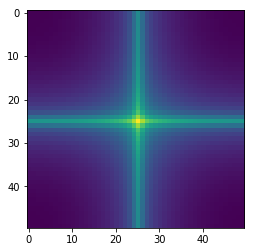

In [50]:
measurements,U,V = UVCreator(np.fft.fftshift(img_fft),mask)

measurements_abs = np.log(np.abs(measurements)+0.01)
show_fft_image(measurements_abs, shift=False)


## RBF Model
### Priors and Model

$$
V_{obs}(u,v) = \sum_{i=0}^{N_{b}-1}\alpha_i\phi_i(u,v)
$$

donde $\alpha_i \in \mathbb{R}$ y:

$$\phi_i(u,v) = \left[\begin{array}{c}
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \cos \big\lbrace C_x^iu+C_y^iv\big\rbrace \\
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \sin \big\lbrace C_x^iu+C_y^iv\big\rbrace
\end{array}\right]$$

In [48]:
import theano.tensor as tt

PI = np.pi
def Vobs_function(U,l,alpha,Cx,Cy, numberOfBasis = 2):
    #print "U shape: %s, U type: %s\nl type: %s\nCx and Cy type: %s"%(U.shape, type(U), type(l), type(Cx))
    
    u = U[:,0] - IMAGE_SIZE_X/2
    u_aux = u[:,np.newaxis]
    v = U[:,1] - IMAGE_SIZE_Y/2
    v_aux = v[:,np.newaxis]
    
    Cx_aux = Cx - IMAGE_SIZE_X/2
    Cy_aux = Cy - IMAGE_SIZE_Y/2
    
    A = tt.exp(-1.0/2.0 * (u_aux * u_aux + v_aux * v_aux) * l*l)
    A_aux = A.repeat(numberOfBasis,axis=1)
    print 'Atenuation:'
    print A.eval()
    print 'max: %s, min: %s' % ( np.max(A.eval()), np.min(A.eval() ))
    
    #print "Amplitude shape: %s, Amplitude type: %s" %(A_aux.eval().shape, type(A))
    # argument = 2.0 * PI * (np.outer(u,Cx) + np.outer(v,Cy))
    argument = (u[:,None]*Cx_aux[None,:] + v[:,None]*Cy_aux[None,:])
    #print "argument shape: %s, argument type: %s" %(argument.shape, type(argument))
    
    cosPart = tt.cos(argument)
    sinPart = tt.sin(argument)
    
    print "Cosine:"
    print cosPart.eval()
    print "Sine:"
    print sinPart.eval()
    
    #print "cosPart shape: %s, cosPart type: %s" %(cosPart.eval().shape, type(cosPart))

    RePart = tt.mul(A_aux,cosPart)
    ImPart = tt.mul(A_aux,sinPart)
    
    #print "RePart shape: %s, RePart type: %s" %(RePart.eval().shape, type(cosPart))
    
    alpha_aux = alpha
    #print "alpha shape: %s, alpha type: %s" %(alpha.shape, type(alpha))
    
    return tt.sum(tt.mul(alpha_aux,RePart), axis = 1), tt.sum(tt.mul(alpha_aux,ImPart), axis = 1)

In [51]:
numberOfSamplings = U.shape[0]
numberOfBasis = size

# l = 1
# init_alpha = np.array([1,1])
# init_Cx = np.array([1,1])
# init_Cy = np.array([0,0])
# init_U = np.array([[0,1],[1,0], [1,1]])

l = SIGMA
init_alpha = I.reshape(-1)*l/np.sqrt(2*PI)
init_Cx = Cx
init_Cy = Cy
init_U = U

PHI_Re, PHI_Im = Vobs_function(init_U,l,init_alpha,init_Cx,init_Cy)
print 'Model:'
print np.array([PHI_Re.eval(),PHI_Im.eval()]).T
print 'Mesurements:'
print V

Atenuation:
[[ 0.]
 [ 0.]
 [ 0.]
 ..., 
 [ 0.]
 [ 0.]
 [ 0.]]
max: 1.0, min: 0.0
Cosine:
[[-0.44812751]
 [-0.30908007]
 [-0.16305026]
 ..., 
 [ 0.40802702]
 [ 0.26658483]
 [ 0.11912028]]
Sine:
[[-0.89396965]
 [-0.95103602]
 [-0.98661776]
 ..., 
 [ 0.91296985]
 [ 0.96381146]
 [ 0.99287983]]
Model:
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 ..., 
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
Mesurements:
[[  5.42373834e-01  -2.83106871e-15]
 [  5.42403311e-01   3.36845760e-02]
 [  5.42492680e-01   6.76375857e-02]
 ..., 
 [  5.36465810e-01  -1.35313126e-01]
 [  5.38422111e-01  -1.00801289e-01]
 [  5.40407855e-01  -6.68388574e-02]]


In [ ]:
#from scipy import optimize

numberOfSamplings = U.shape[0]
numberOfBasis = size
rbf_model = Model()

l = SIGMA
init_alpha = I.reshape(-1)*l
init_Cx = Cx
init_Cy = Cy
init_sigma = np.abs(10*np.random.randn(2,2))

with rbf_model:
    alpha_model = Normal('alpha', mu=init_alpha, sd=5, shape = [1,numberOfBasis])
    Cx_model = Normal('Cx', mu=init_Cx, sd=5, shape = numberOfBasis)
    Cy_model = Normal('Cy', mu=init_Cy, sd=5, shape = numberOfBasis)
    l_model = HalfNormal('l', sd=1, shape = 1)
    sigma_model = Lognormal('sigma', init_sigma, np.ones(2), shape=(2,2), testval=init_sigma)
    a = Normal('a', mu=1, sd=10, shape = 1)
    b = Normal('b', mu=1, sd=10, shape = 1)
    c = Normal('c', mu=1, sd=10, shape = 1)
    sigma_model.reshape((2,2))

    PHI_Re, PHI_Im = Vobs_function(U, l_model, alpha_model, Cx_model, Cy_model)
    V_model = tt.stack([PHI_Re, PHI_Im], axis = 1)
    
    V_obs = MvNormal('V_obs', mu=V_model, cov=sigma_model, observed=V)
    
    n_samples = 1000
    #step = Slice()
    #sample(n_samples, step)
    estimation = find_MAP(model = rbf_model)
    print estimation

In [ ]:
init_sigma